# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [3]:
from cs231n.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for the bonus section.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

HSL和HSV都是一种将RGB色彩模型中的点在圆柱坐标系中的表示法。这两种表示法试图做到比RGB基于笛卡尔坐标系的几何结构更加直观。

HSL即色相、饱和度、亮度（英语：Hue, Saturation, Lightness）。HSV即色相、饱和度、明度（英语：Hue, Saturation, Value），又称HSB，其中B即英语：Brightness。

    色相（H）是色彩的基本属性，就是平常所说的颜色名称，如红色、黄色等。
    饱和度（S）是指色彩的纯度，越高色彩越纯，低则逐渐变灰，取0-100%的数值。
    明度（V），亮度（L），取0-100%。

HSL和HSV二者都把颜色描述在圓柱坐標系内的点，这个圆柱的中心轴取值为自底部的黑色到顶部的白色而在它们中间的是灰色，绕这个轴的角度对应于“色相”，到这个轴的距离对应于“饱和度”，而沿着这个轴的高度对应于“亮度”，“色调”或“明度”。

这两种表示在目的上类似，但在方法上有区别。二者在数学上都是圆柱，但HSV（色相，饱和度，明度）在概念上可以被认为是颜色的倒圆锥体（黑点在下顶点，白色在上底面圆心），HSL在概念上表示了一个双圆锥体和圆球体（白色在上顶点，黑色在下顶点，最大横切面的圆心是半程灰色）。注意尽管在HSL和HSV中“色相”指称相同的性质，它们的“饱和度”的定义是明显不同的。

因为HSL和HSV是设备依赖的RGB的简单变换，(h, s, l)或 (h, s, v)三元组定义的颜色依赖于所使用的特定红色、绿色和蓝色“加法原色”。每个独特的RGB设备都伴随着一个独特的HSL和HSV空间。但是 (h, s, l)或 (h, s, v)三元组在被约束于特定RGB空间比如sRGB的时候就更明确了。
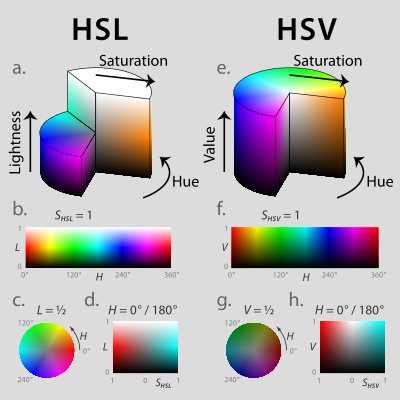

In [68]:
from cs231n.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)] # 这里是因为要更改参数，而且后面的函数必须有img参数的输入
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [86]:
# Use the validation set to tune the learning rate and regularization strength

from cs231n.classifiers.linear_classifier import LinearSVM

learning_rates = [1e-9, 1e-8, 1e-7, 1e-6]
regularization_strengths = [1e4,5e4,1e5, 5e5,1e6, 5e6,1e7]
bins = [8,10,12,14]

results = {}
best_val = -1
best_svm = None

# pass
################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################
# pass

for lr in learning_rates:
    for reg in regularization_strengths:
        #for num_bin in bins:
            svm = LinearSVM()
            loss_hist = svm.train(X_train_feats, y_train, learning_rate=lr, reg=reg, num_iters=1500)
        
            y_train_pred = svm.predict(X_train_feats)
            acc_train = np.mean(y_train_pred==y_train)

            y_val_pred = svm.predict(X_val_feats)
            acc_val = np.mean(y_val==y_val_pred)

            results[(lr, reg)] = [acc_train, acc_val]

            if acc_val > best_val:
                best_val = acc_val
                best_svm = svm
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

/home/lily/Datageek/cs231nhomework/assignment1/cs231n/classifiers/linear_svm.py:110: RuntimeWarning: overflow encountered in multiply
  dW += 2 * reg * W
/home/lily/Datageek/cs231nhomework/assignment1/cs231n/classifiers/linear_svm.py:105: RuntimeWarning: invalid value encountered in greater
  mask[margins>0] = 1
/home/lily/Datageek/cs231nhomework/assignment1/cs231n/classifiers/linear_classifier.py:76: RuntimeWarning: invalid value encountered in add
  self.W += -learning_rate * grad # 这里直接使用self.W -= learning_rate*grad会有警告说计算移溢出


lr 1.000000e-09 reg 1.000000e+04 train accuracy: 0.094327 val accuracy: 0.106000
lr 1.000000e-09 reg 5.000000e+04 train accuracy: 0.111163 val accuracy: 0.089000
lr 1.000000e-09 reg 1.000000e+05 train accuracy: 0.080490 val accuracy: 0.088000
lr 1.000000e-09 reg 5.000000e+05 train accuracy: 0.108388 val accuracy: 0.091000
lr 1.000000e-09 reg 1.000000e+06 train accuracy: 0.084061 val accuracy: 0.085000
lr 1.000000e-09 reg 5.000000e+06 train accuracy: 0.419245 val accuracy: 0.426000
lr 1.000000e-09 reg 1.000000e+07 train accuracy: 0.408224 val accuracy: 0.403000
lr 1.000000e-08 reg 1.000000e+04 train accuracy: 0.101163 val accuracy: 0.117000
lr 1.000000e-08 reg 5.000000e+04 train accuracy: 0.083551 val accuracy: 0.074000
lr 1.000000e-08 reg 1.000000e+05 train accuracy: 0.109143 val accuracy: 0.116000
lr 1.000000e-08 reg 5.000000e+05 train accuracy: 0.414347 val accuracy: 0.421000
lr 1.000000e-08 reg 1.000000e+06 train accuracy: 0.411816 val accuracy: 0.405000
lr 1.000000e-08 reg 5.000000

In [87]:
# Evaluate your trained SVM on the test set
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.406


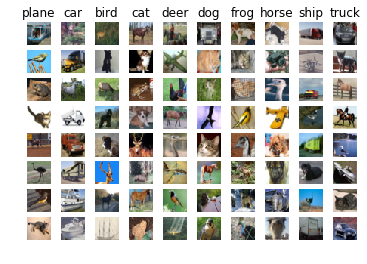

In [88]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?  
有一些能够看出类似的pattern,例如鸟，中间的麋鹿的角和背景颜色像是展开的鸟。但是大部分看不出来有什么相关性。可能是因为用梯度直方图和颜色直方图，很容易通过背景颜色以及某些范围的大的特征来给予判断。

## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [89]:
print(X_train_feats.shape)

(49000, 155)


In [115]:
from cs231n.classifiers.neural_net import TwoLayerNet

input_dim = X_train_feats.shape[1]
hidden_dim = 500
num_classes = 10

# net = TwoLayerNet(input_dim, hidden_dim, num_classes)
best_net = None

################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
# pass
best_acc = -1
hidden_sizes = [500,512,1024,1500,1536]
learning_rates = [1.0,1e-1,1e-2,1e-3, 5e-4, 1e-4, 5e-5]
regularization_strengths = [1e-4,1e-3,3e-3,1e-2,1e-1,1]

results = {}
for hs in hidden_sizes:
    for lr in learning_rates:
        for reg in regularization_strengths:
            net = TwoLayerNet(input_dim, hs, num_classes)
            
            stats = net.train(X_train_feats, y_train, X_val_feats, y_val, num_iters=1000, batch_size=200,
                              learning_rate=lr, learning_rate_decay = 0.95, reg=reg, verbose=False)
            
            y_val_pred = net.predict(X_val_feats)
            acc_val = np.mean(y_val_pred == y_val)
            results[(hs,lr,reg)] = acc_val
            
            if acc_val > best_acc:
                best_acc = acc_val
                best_net = net

################################################################################
#                              END OF YOUR CODE                                #
################################################################################
for hs, lr, reg in sorted(results):
    val_accuracy = results[(hs, lr, reg)]
    print('hs %d lr %e reg %e val accuracy: %f' % (
                hs, lr, reg,val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_acc)

/home/lily/Datageek/cs231nhomework/assignment1/cs231n/classifiers/neural_net.py:113: RuntimeWarning: divide by zero encountered in log
  loss = -np.sum(np.log(correct_exp/exp_den))/N + reg * np.sum(W1 * W1) + reg * np.sum(W2 * W2)
/home/lily/Datageek/cs231nhomework/assignment1/cs231n/classifiers/neural_net.py:107: RuntimeWarning: overflow encountered in subtract
  scores -= scores.max(axis=1).reshape(-1,1)
/home/lily/Datageek/cs231nhomework/assignment1/cs231n/classifiers/neural_net.py:107: RuntimeWarning: invalid value encountered in subtract
  scores -= scores.max(axis=1).reshape(-1,1)
/home/lily/tf3.6/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)
/home/lily/Datageek/cs231nhomework/assignment1/cs231n/classifiers/neural_net.py:135: RuntimeWarning: invalid value encountered in less
  dZ1 = dA1 # (N,H)


hs 500 lr 5.000000e-05 reg 1.000000e-04 val accuracy: 0.084000
hs 500 lr 5.000000e-05 reg 1.000000e-03 val accuracy: 0.078000
hs 500 lr 5.000000e-05 reg 3.000000e-03 val accuracy: 0.070000
hs 500 lr 5.000000e-05 reg 1.000000e-02 val accuracy: 0.078000
hs 500 lr 5.000000e-05 reg 1.000000e-01 val accuracy: 0.077000
hs 500 lr 5.000000e-05 reg 1.000000e+00 val accuracy: 0.086000
hs 500 lr 1.000000e-04 reg 1.000000e-04 val accuracy: 0.078000
hs 500 lr 1.000000e-04 reg 1.000000e-03 val accuracy: 0.078000
hs 500 lr 1.000000e-04 reg 3.000000e-03 val accuracy: 0.078000
hs 500 lr 1.000000e-04 reg 1.000000e-02 val accuracy: 0.079000
hs 500 lr 1.000000e-04 reg 1.000000e-01 val accuracy: 0.088000
hs 500 lr 1.000000e-04 reg 1.000000e+00 val accuracy: 0.078000
hs 500 lr 5.000000e-04 reg 1.000000e-04 val accuracy: 0.079000
hs 500 lr 5.000000e-04 reg 1.000000e-03 val accuracy: 0.079000
hs 500 lr 5.000000e-04 reg 3.000000e-03 val accuracy: 0.079000
hs 500 lr 5.000000e-04 reg 1.000000e-02 val accuracy: 0

In [117]:
# Run your neural net classifier on the test set. You should be able to
# get more than 55% accuracy.

test_acc = (best_net.predict(X_test_feats) == y_test).mean()
print(test_acc)

0.585


# Bonus: Design your own features!

You have seen that simple image features can improve classification performance. So far we have tried HOG and color histograms, but other types of features may be able to achieve even better classification performance.

For bonus points, design and implement a new type of feature and use it for image classification on CIFAR-10. Explain how your feature works and why you expect it to be useful for image classification. Implement it in this notebook, cross-validate any hyperparameters, and compare its performance to the HOG + Color histogram baseline.

# Bonus: Do something extra!
Use the material and code we have presented in this assignment to do something interesting. Was there another question we should have asked? Did any cool ideas pop into your head as you were working on the assignment? This is your chance to show off!